# 0 环境配置

In [1]:
import numpy as np
import os
import sys, time
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

from model.loss import change_mask_loss
from model.metric import change_mask_all_accuracy, change_mask_change_accuracy
from keras.applications.xception import preprocess_input
from keras.callbacks import Callback, EarlyStopping
from model.DepthwiseConv2D import DepthwiseConv2D
from model.switchnorm import SwitchNormalization
from keras.utils import multi_gpu_model
from keras.optimizers import *
from keras.models import load_model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from dataload.data_generator_random import *
from model.core_model import model_v5 as my_model

gpus = 2
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.95
session = tf.Session(config=config)


/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1 预设参数

In [2]:
base_project = os.path.abspath('../')
data_dir    = os.path.join(base_project, 'dataspace')
model_name = 'model_v5'
image_size = (512, 512)
model_layer = 'mixed7'
mask_size  = (63, 63)

# 2 数据生成

In [3]:
threshold = 0.12
heatmap_height = mask_size[0]
heatmap_width  = mask_size[1]

train_batch_size = 16
valid_batch_size = 16


train_gen = MyImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=6,
    channel_shift_range=15,
    zoom_range=(.9, 1.1),
    horizontal_flip=True
)

gen = MyImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.myflow_from_directory(os.path.join(data_dir, 'train'),
                                                  target_size       = image_size,
                                                  x_threshold        = threshold,
                                                  y_threshold        = threshold,
                                                  simple_take_flag  = False,
                                                  heatmap_height    = heatmap_height,
                                                  heatmap_width     = heatmap_width,
                                                  batch_size        = train_batch_size)

valid_generator = gen.myflow_from_directory(os.path.join(data_dir, 'valid'), 
                                           target_size       = image_size,
                                           x_threshold        = threshold,
                                           y_threshold        = threshold,
                                           simple_take_flag  = True,
                                           heatmap_height    = heatmap_height,
                                           heatmap_width     = heatmap_width,
                                           batch_size        = valid_batch_size)
train_samples_epoch = train_generator.data_num
print("samples_train_epoch = {}".format(train_samples_epoch))

steps_train = len(train_generator)
print("steps_train = {}".format(steps_train))

valid_samples_epoch = valid_generator.data_num
print("samples_valid_epoch = {}".format(valid_samples_epoch))

steps_valid = len(valid_generator)
print("steps_valid = {}".format(steps_valid))

# 3 搭建模型

basic_directory numbers: 0
Found 0 data.
basic_directory numbers: 0
Found 0 data.
samples_train_epoch = 0
steps_train = 0
samples_valid_epoch = 0
steps_valid = 0


# 3 搭建模型

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 63, 63, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
mp_conv_1 (Conv2D)              (None, 63, 63, 16)   144         input_3[0][0]                    
__________________________________________________________________________________________________
vision_mod

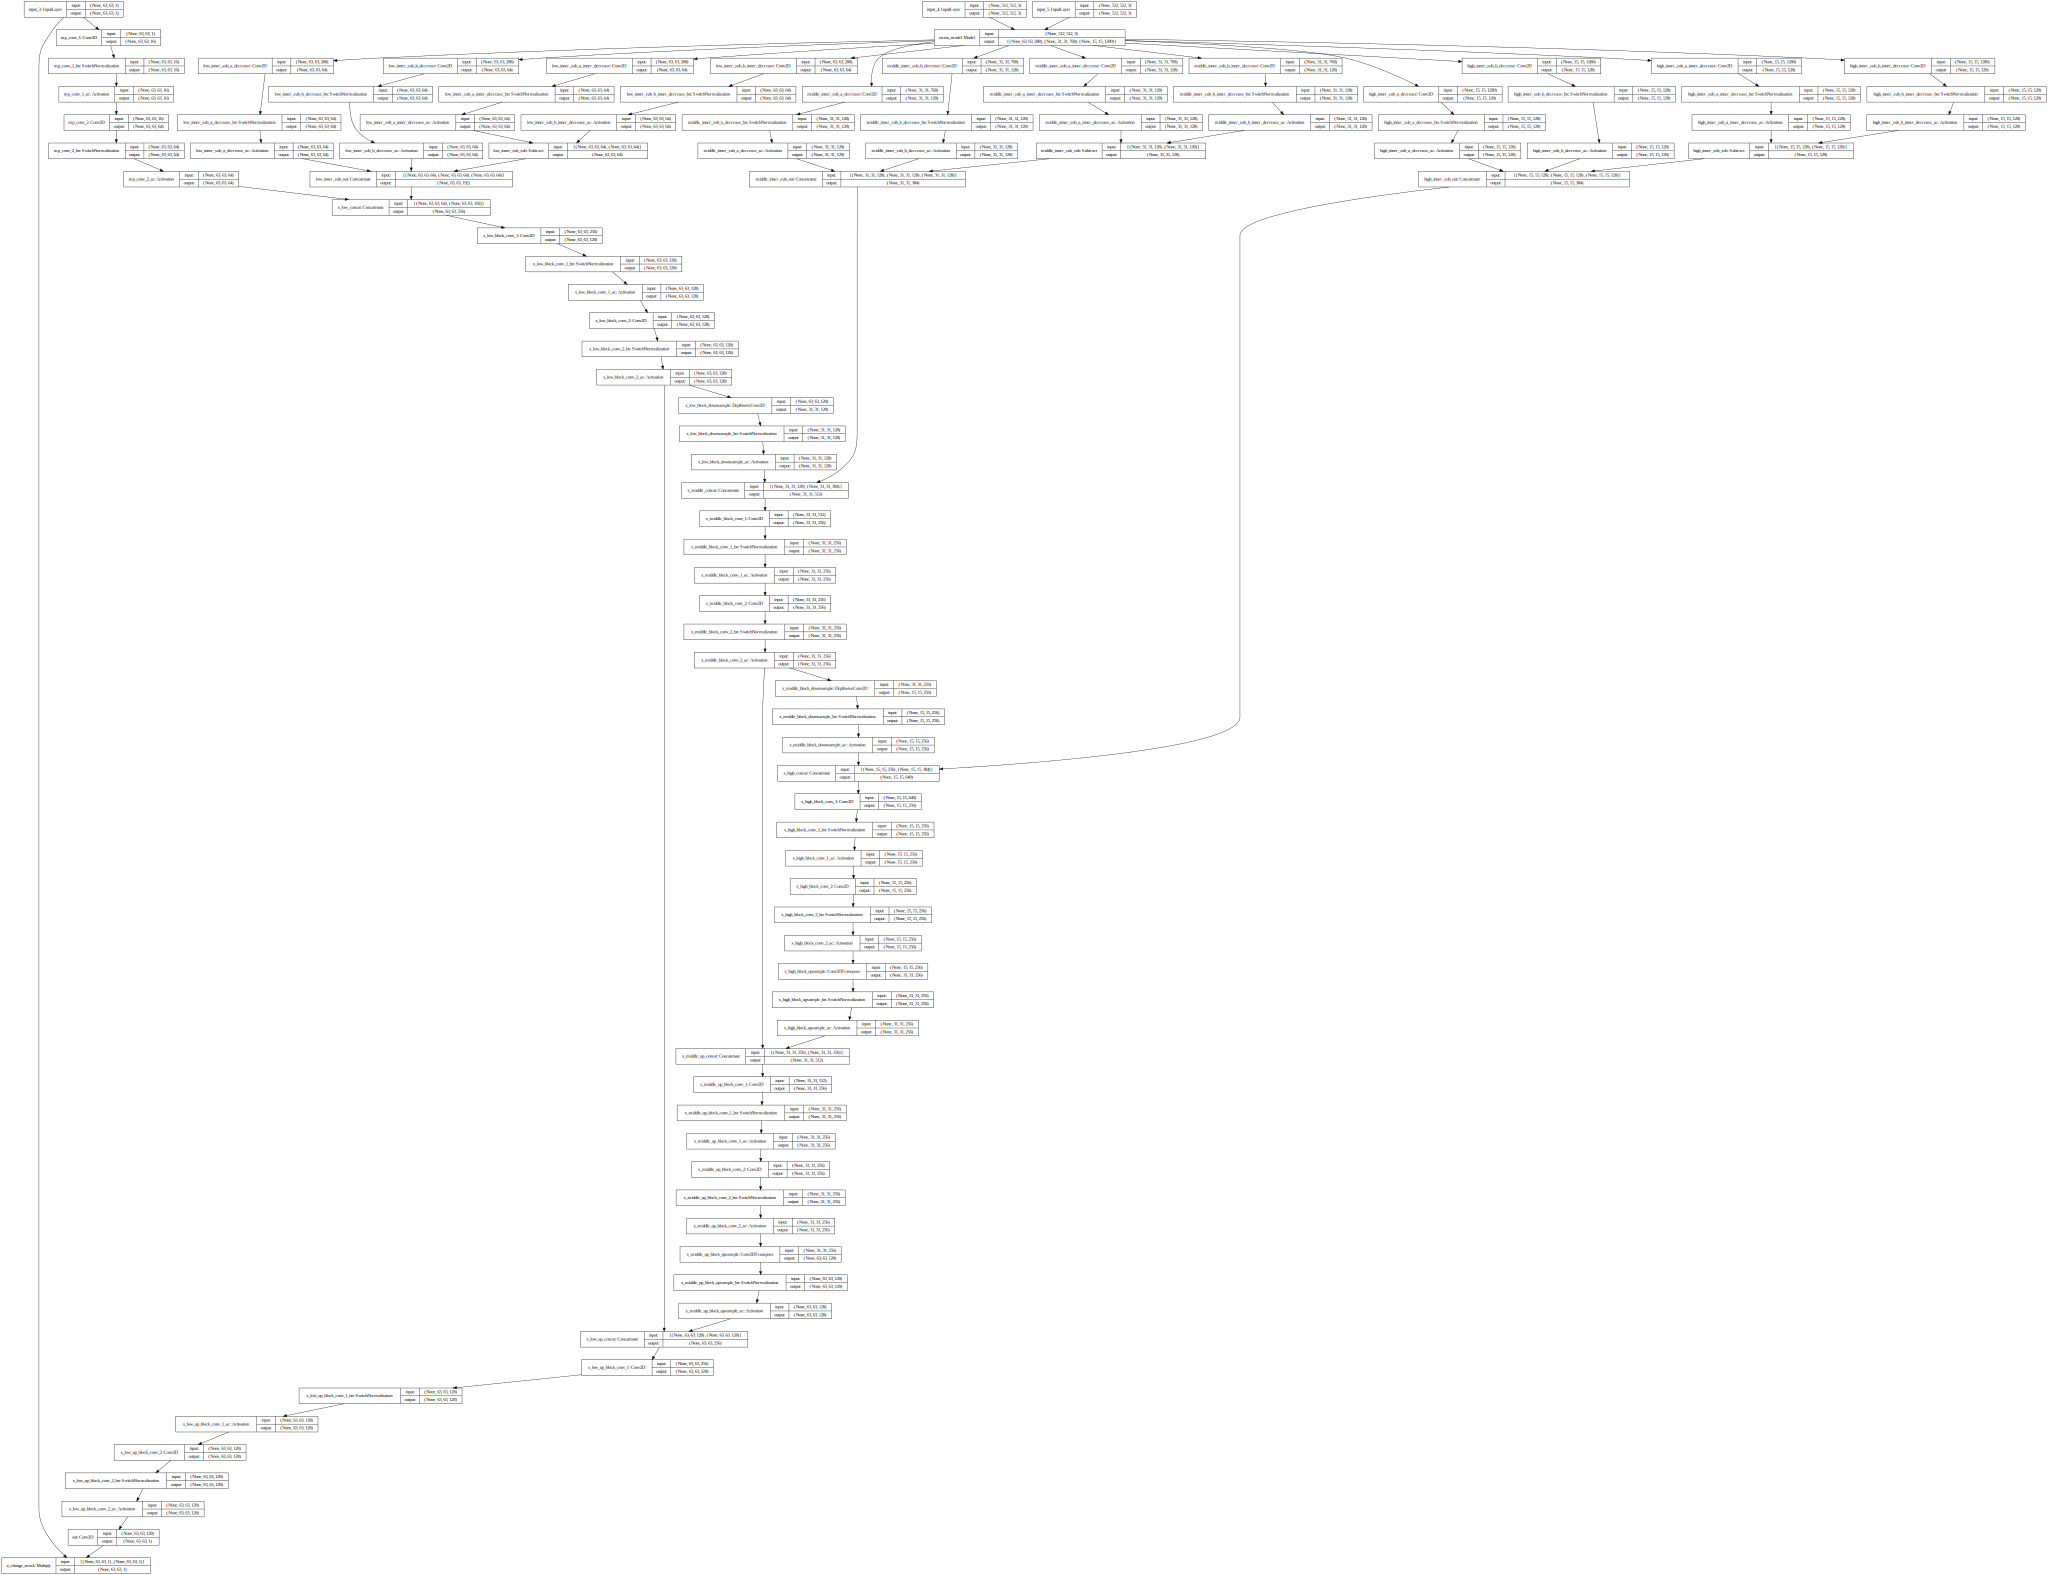

In [4]:
model = my_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 4 训练模型

In [7]:
model_path = os.path.join(base_project,  'checkpoints/' + model_name)

if not os.path.exists(model_path):
    os.makedirs(model_path)

class MyModelCheckpoint(Callback):
    def __init__(self, model, path, init_loss=np.inf, init_acc=-1):
        self.mymodel = model
        self.path = path
        self.best_loss = init_loss
        self.best_acc = init_acc
        
    def on_epoch_end(self, epoch, logs=None):
        stamp = time.strftime('%Y%m%d%H%M',time.localtime(time.time()))

        val_loss = logs['val_loss']
        val_acc = logs['val__all_accuracy']

        _model = '{}_{}_{:.4f}_{:.4f}{}'.format(model_name, stamp, val_loss, val_acc, '_model.h5')
        model_path = os.path.join(self.path, _model)
        short_name = '{}.h5'.format(model_name)
        
        if val_loss < self.best_loss:
            print("\nValidation loss decreased from {:.4f} to {:.4f}, saving model to {}".format(self.best_loss, val_loss, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_loss = val_loss
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                
        elif val_acc > self.best_acc:
            print("\nValidation acc increased from {:.4f} to {:.4f}, saving model to {}".format(self.best_acc, val_acc, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_acc = val_acc
            if val_loss < self.best_loss:
                self.best_loss = val_loss

In [9]:
checkpoint = MyModelCheckpoint(model, model_path, init_loss = .05, init_acc = .93)
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v5_201901040920_0.0252_0.9438_model.h5'))

In [10]:
multi_model = multi_gpu_model(model, gpus=gpus)

multi_model.compile(optimizer = Adam(lr=1e-3), 
                    loss      = change_mask_loss(),
                    metrics   = [change_mask_all_accuracy(), change_mask_change_accuracy()])

multi_model.fit_generator(train_generator, 
                          steps_per_epoch  = steps_train, 
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid, 
                          max_queue_size   = 64, 
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

Epoch 1/100
1211/1211 [==============================] - 1364s 1s/step - loss: 2.7240 - _all_accuracy: 0.5349 - _change_accuracy: 0.9671 - val_loss: 2.9313 - val__all_accuracy: 0.5030 - val__change_accuracy: 0.9733

Validation loss decreased from inf to 2.93126, saving model
Epoch 2/100
1211/1211 [==============================] - 1292s 1s/step - loss: 1.8373 - _all_accuracy: 0.6119 - _change_accuracy: 0.9757 - val_loss: 2.3122 - val__all_accuracy: 0.5464 - val__change_accuracy: 0.9725

Validation loss decreased from 2.93126 to 2.31218, saving model
Epoch 3/100
1211/1211 [==============================] - 1296s 1s/step - loss: 1.6835 - _all_accuracy: 0.6372 - _change_accuracy: 0.9776 - val_loss: 2.1283 - val__all_accuracy: 0.5606 - val__change_accuracy: 0.9757

Validation loss decreased from 2.31218 to 2.12828, saving model
Epoch 4/100
1211/1211 [==============================] - 1296s 1s/step - loss: 1.6254 - _all_accuracy: 0.6464 - _change_accuracy: 0.9776 - val_loss: 2.0432 - val__a

In [11]:
model.load_weights(os.path.join(model_path, 'model_v5.h5'))

/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
multi_model = multi_gpu_model(model, gpus=gpus)

multi_model.compile(optimizer = Adam(lr=1e-4), 
                    loss      = change_mask_loss(),
                    metrics   = [change_mask_all_accuracy(), change_mask_change_accuracy()])

multi_model.fit_generator(train_generator, 
                          steps_per_epoch  = steps_train,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

Epoch 1/100
1211/1211 [==============================] - 1365s 1s/step - loss: 1.1865 - _all_accuracy: 0.7159 - _change_accuracy: 0.9820 - val_loss: 1.5678 - val__all_accuracy: 0.6368 - val__change_accuracy: 0.9768

Validation loss decreased from 1.63549 to 1.56776, saving model
Epoch 2/100
1211/1211 [==============================] - 1292s 1s/step - loss: 1.1524 - _all_accuracy: 0.7245 - _change_accuracy: 0.9824 - val_loss: 1.6008 - val__all_accuracy: 0.6431 - val__change_accuracy: 0.9743
Epoch 3/100
1211/1211 [==============================] - 1289s 1s/step - loss: 1.1339 - _all_accuracy: 0.7258 - _change_accuracy: 0.9825 - val_loss: 1.5654 - val__all_accuracy: 0.6461 - val__change_accuracy: 0.9748

Validation loss decreased from 1.56776 to 1.56540, saving model
Epoch 4/100
1211/1211 [==============================] - 1289s 1s/step - loss: 1.1143 - _all_accuracy: 0.7297 - _change_accuracy: 0.9827 - val_loss: 1.5899 - val__all_accuracy: 0.6422 - val__change_accuracy: 0.9751
Epoch 5/10

In [ ]:
model.load_weights(os.path.join(model_path, 'model_v5.h5'))

In [ ]:
multi_model = multi_gpu_model(model, gpus=gpus)

multi_model.compile(optimizer = Adam(lr=1e-5), 
                    loss      = change_mask_loss(),
                    metrics   = [change_mask_all_accuracy(), change_mask_change_accuracy()])

multi_model.fit_generator(train_generator, 
                          steps_per_epoch  = steps_train, 
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid, 
                          max_queue_size   = 64, 
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

# 5 测试模型

In [13]:
model = load_model(savemodel_path, custom_objects={'DepthwiseConv2D': DepthwiseConv2D, 'SwitchNormalization': SwitchNormalization})
multi_model = multi_gpu_model(model, gpus=2)

/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
test_generator = gen.myflow_from_directory(os.path.join(data_dir, 'valid'),  image_size,
                                          simple_take_flag=True, batch_size=valid_batch_size)

basic_directory numbers: 496
Found 4837 data.


In [17]:
multi_model.compile(optimizer=Adam(lr=1e-4), 
              loss=change_mask_loss(),
              metrics=[change_mask_all_accuracy(), change_mask_change_accuracy()])

multi_model.evaluate_generator(test_generator, steps=steps_valid)

[0.27534748157228905, 0.9453171577729058, 0.9981369761260088]

In [19]:
test_generator = gen.myflow_from_directory(os.path.join(data_dir, 'valid'),  image_size,
                                          simple_take_flag=True, batch_size=valid_batch_size, return_path = True)

basic_directory numbers: 496
Found 4837 data.


In [20]:
heatmap_a_all_temp = np.ones((train_batch_size, 31, 31, 1), dtype=np.uint8)
show_list = []
for i in range(5):
    x, y, path_list = test_generator.next()
    heatmap_a_all_true = x[2]
    x[2] = heatmap_a_all_temp
    y_pred = multi_model.predict(x)
    y_pred_true = np.round(y_pred) * heatmap_a_all_true
    y_label = y
    for a_mask, y_pred_true_one, y_label_one, y_pred_one, path in zip(heatmap_a_all_true, y_pred_true, y_label, y_pred, path_list):
        if not np.array_equal(y_pred_true_one, y_label_one):
            show_list.append([path, a_mask, y_label_one, y_pred_one, np.not_equal(y_pred_true_one, y_label_one).astype(np.uint8)])

In [21]:
len(show_list)

4

In [22]:
import cv2

In [31]:
def add_weight(img, cam, weight_img=1, weight_cam=1, if_filter=False):
    cam = cv2.resize(cam, (512, 512), interpolation=cv2.INTER_NEAREST)
    if if_filter:
        #img[np.where(cam == 1)] = 0  # bug?
        heatmap = np.tile(np.uint8(255*cam)[:, :, np.newaxis], (1, 1, 3))
    else:
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.5)] = 0
    out = cv2.addWeighted(img, weight_img, heatmap, weight_cam, 0)
    out = out[:, :, ::-1]
    return out

第1个错误
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_104-4/2/11-43-54_4.jpg
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_104-4/2/11-45-24_4.jpg


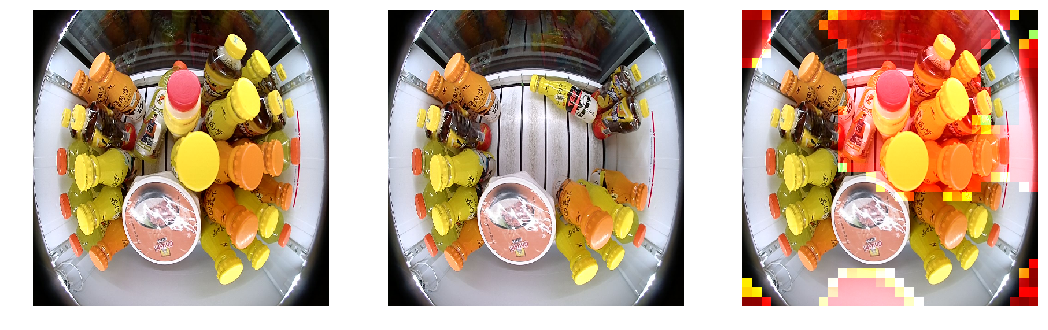

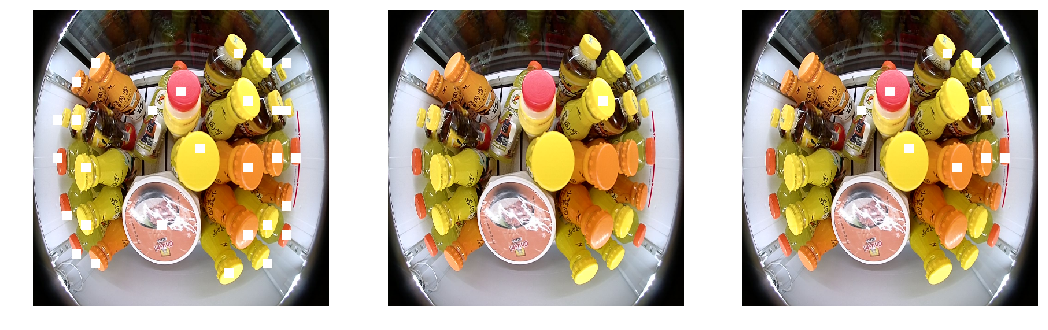

第2个错误
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_104-4/40/11-12-52_4.jpg
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_104-4/40/11-15-25_4.jpg


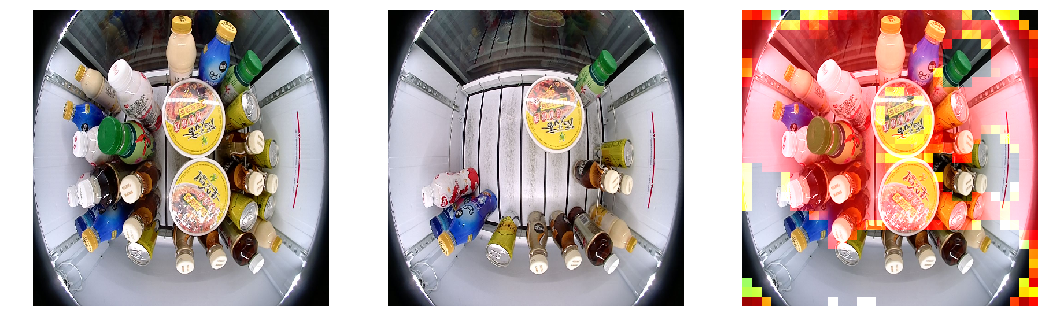

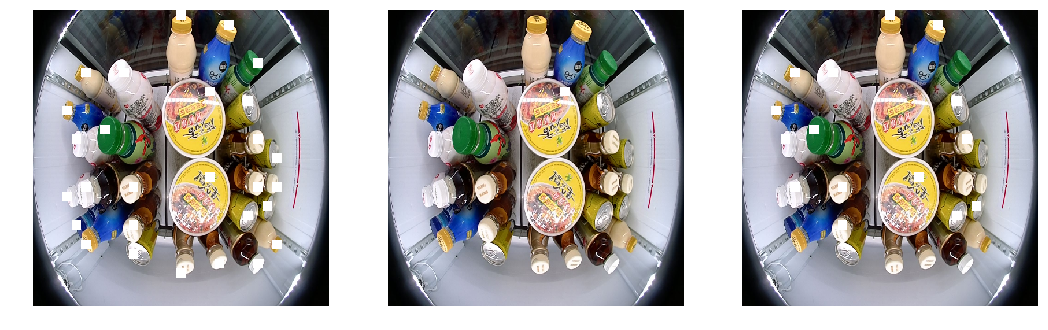

第3个错误
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_242-1/37/16-57-51_1.jpg
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_242-1/37/16-58-43_1.jpg


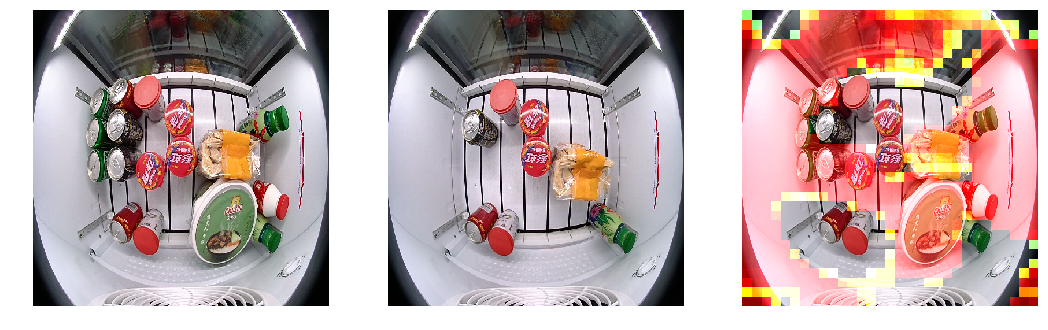

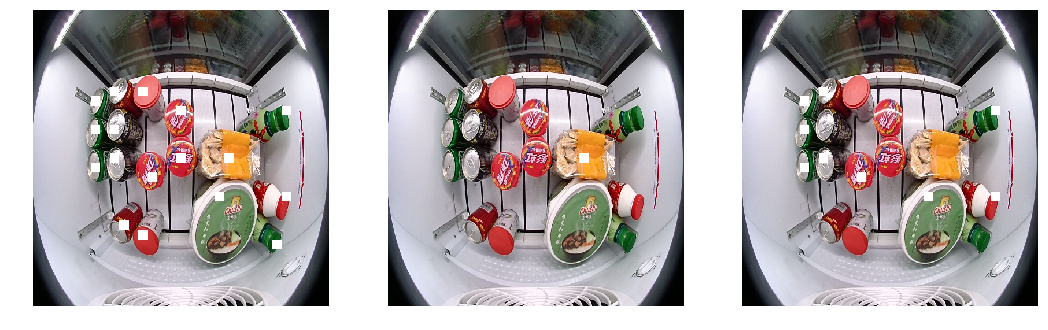

第4个错误
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_119-3/35/16-37-29_3.jpg
/home/ubuntu/WorkSpace/DataSpace/M3_counting/data_spilit/plan1/valid/task87_6_119-3/35/16-38-20_3.jpg


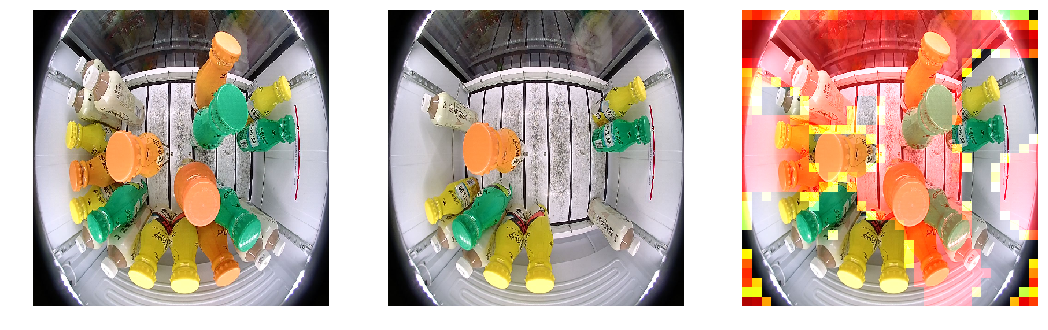

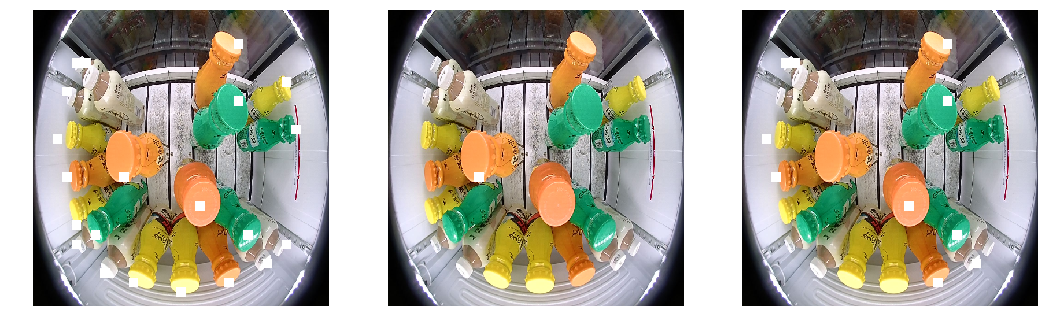

In [34]:
for i, x in enumerate(show_list):
    path, a_mask, y_label_one, y_pred_one, un_equal = x
    a_path, b_path = path[0], path[1]
    img_a = load_img(os.path.join(a_path), target_size=(512, 512))
    a = img_to_array(img_a, data_format='channels_last', dtype='uint8')
    img_b = load_img(os.path.join(b_path), target_size=(512, 512))
    b = img_to_array(img_b, data_format='channels_last', dtype='uint8')
    img = cv2.imread(a_path)
    img = cv2.resize(img,  (512, 512))
    pred_out = add_weight(img, y_pred_one)
    mask_out = add_weight(img, a_mask, if_filter=True)
    un_equal_out = add_weight(img, un_equal, if_filter=True)
    label_out = add_weight(img, y_label_one, if_filter=True)
    print("第{0}个错误".format(i+1))
    print(a_path)
    print(b_path)
    display_images([a, b, pred_out], cols=3)
    display_images([mask_out, un_equal_out, label_out], cols=3)